In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from utils import *

plt.style.use('deeplearning.mplstyle')

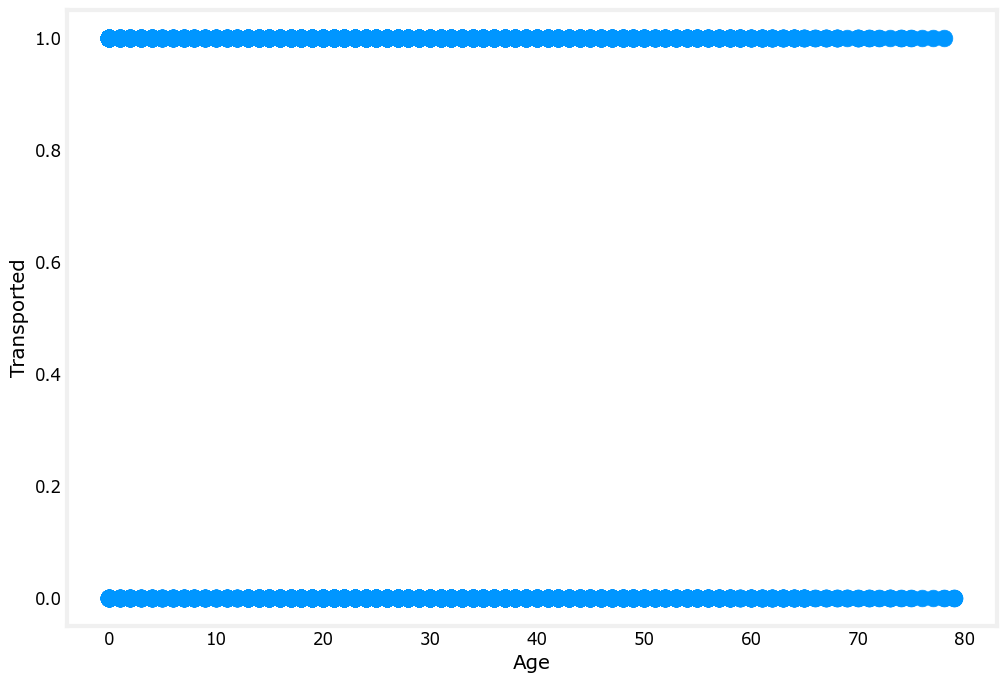

In [3]:
# viewing the features in relation the target data
filepath = './data/train.csv'
visual = pd.read_csv(filepath)
plt.scatter(visual['Age'], visual['Transported'])
plt.xlabel('Age')
plt.ylabel('Transported')
plt.show()

In [15]:
train_data = modify_data(filepath)
X = train_data.drop(['Transported'], axis=1)
Y = train_data['Transported']

x_tra, x_cv, Y_tra, y_cv = train_test_split(X, Y, test_size=0.2, random_state=42)
print(x_tra.shape)
print(x_cv.shape)
print(Y_tra.shape)
print(y_cv.shape)

Data before preprocessing...
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3      

In [22]:
# Training a Logistic Regression Model
degree = 3
threshold = 0.53
models = []
scalers = []
polys = []
accuracy_scores = np.zeros((degree, 2))
for i in range(1, degree+1):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    x_tra_poly = poly.fit_transform(x_tra)
    x_cv_poly = poly.fit_transform(x_cv)
    polys.append(poly)
    
    scaler = StandardScaler()
    X_mapped = scaler.fit_transform(x_tra_poly)
    X_cv_mapped = scaler.transform(x_cv_poly)
    scalers.append(scaler)
    
    print(f'Training Model with degree {i}...')
    model = LogisticRegression(max_iter=1000)
    model.fit(X_mapped, Y_tra)
    models.append(model)
    print(f'Model Trained with degree {i}')
    
    yhat = model.predict_proba(X_mapped)[:, 1]
    yhat = np.where(yhat >= threshold, 1, 0)
    accuracy_scores[i-1, 0] = accuracy_score(Y_tra, yhat)
    
    yhatcv = model.predict_proba(X_cv_mapped)[:, 1]
    yhatcv = np.where(yhatcv >= threshold, 1, 0)
    accuracy_scores[i-1, 1] = accuracy_score(y_cv, yhatcv)
    
    
for i in range(degree):
    print(f'Degree {i+1} Accuracy Score: {accuracy_scores[i]}')
    

Training Model with degree 1...
Model Trained with degree 1
Training Model with degree 2...
Model Trained with degree 2
Training Model with degree 3...
Model Trained with degree 3
Degree 1 Accuracy Score: [0.75539258 0.74698102]
Degree 2 Accuracy Score: [0.78027035 0.76020702]
Degree 3 Accuracy Score: [0.79134311 0.76365727]


In [23]:
# Scaling of data for other models
scaling = StandardScaler()
x_tra_scale = scaling.fit_transform(x_tra)
x_cv_scale = scaling.transform(x_cv)
print(x_tra_scale[:2])

[[-0.05794566 -0.15148573 -0.333264   -0.25773351 -0.28924819 -0.28924819
  -0.26274904  0.94023522 -0.56926885 -0.50049427 -0.1573431   0.72595401
  -0.72595401 -0.51282144 -0.31672773  0.68502438 -0.14281521]
 [-0.82767203 -0.15148573 -0.333264    0.4736217  -0.23814341 -0.23814341
  -0.26274904  0.94023522 -0.56926885 -0.50049427 -0.1573431   0.72595401
  -0.72595401 -0.51282144 -0.31672773  0.68502438 -0.14281521]]


In [24]:
# Training an Ensemble Classifier Model
rf_model = build_rf()
threshold_rf = 0.56
accuracy_scores_rf = np.zeros((3, 2))
r = 0
for rf in rf_model:

    rf.fit(x_tra_scale, Y_tra)
    
    yhat_rf = rf.predict_proba(x_tra_scale)[:, 1]
    yhat_rf = np.where(yhat_rf >= threshold_rf, 1, 0)
    accuracy_scores_rf[r, 0] = accuracy_score(Y_tra, yhat_rf)
    
    yhat_cv_rf = rf.predict_proba(x_cv_scale)[:, 1]
    yhat_cv_rf = np.where(yhat_cv_rf >= threshold_rf, 1, 0)
    accuracy_scores_rf[r, 1] = accuracy_score(y_cv, yhat_cv_rf)
    
    r += 1
    
for f in range(3):
    print(f'The Accuracy Score for {rf_model[f].name}: {accuracy_scores_rf[f]}')


The Accuracy Score for rf1: [0.78573483 0.77630822]
The Accuracy Score for rf2: [0.89229221 0.76078206]
The Accuracy Score for rf3: [0.8307449  0.77170788]


In [25]:
# Training a Neural Network
nn_model = build_nn()
threshold_nn = 0.57
accuracy_scores_nn = np.zeros((3, 2))
i = 0
for nn in nn_model:
    
    nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
    
    print(f'Training {nn.name}...')
    
    nn.fit(x_tra_scale, Y_tra, epochs=150, verbose=0)
    
    print(f'{nn.name} trained')
    
    yhat_nn = nn.predict(x_tra_scale)
    yhat_nn = tf.math.sigmoid(yhat_nn)
    yhat_nn = np.where(yhat_nn >= threshold_nn, 1, 0)
    accuracy_scores_nn[i, 0] = accuracy_score(Y_tra, yhat_nn)
    
    yhat_cv_nn = nn.predict(x_cv_scale)
    yhat_cv_nn = tf.math.sigmoid(yhat_cv_nn)
    yhat_cv_nn = np.where(yhat_cv_nn >= threshold_nn, 1, 0)
    accuracy_scores_nn[i, 1] = accuracy_score(y_cv, yhat_cv_nn)
    
    i += 1
    
for j in range(3):
    print(f'The Accuracy Score for {nn_model[j].name}: {accuracy_scores_nn[j]}')
    

Training model1...
model1 trained
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training model2...
model2 trained
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training model3...
model3 trained
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
The Accuracy Score for model1: [0.82297958 0.7492812 ]
The Accuracy Score for model2: [0.83894162 0.75618171]
The Accuracy Score for model3: [0.80529192 0.7613571 ]


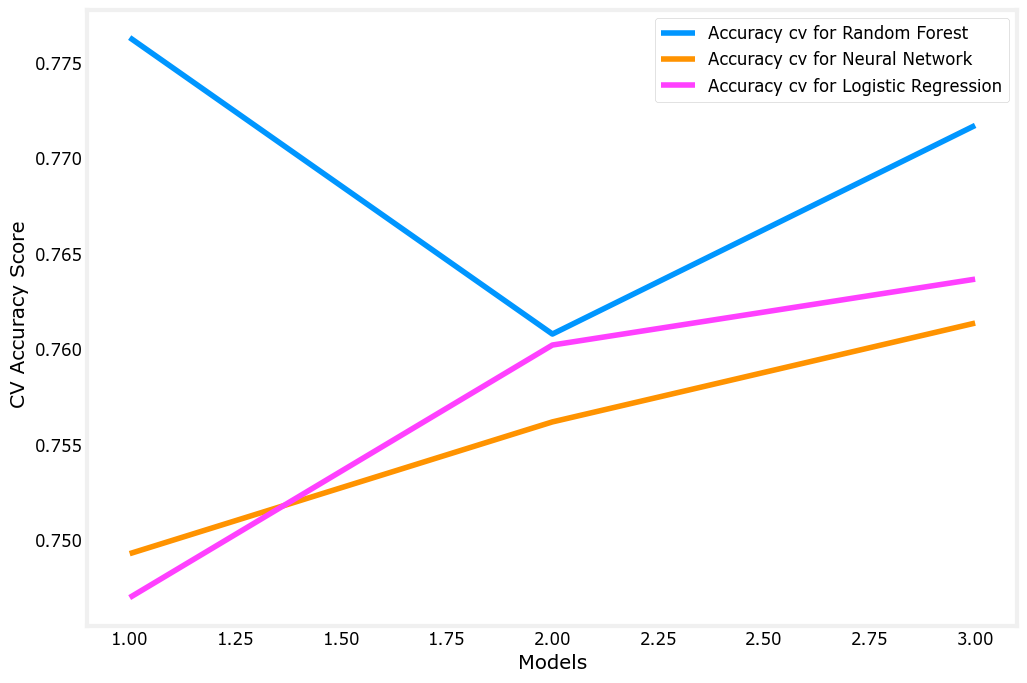

In [26]:
# Viewing the accuracy score of the models
plt.plot(range(1, 4), accuracy_scores_rf[:, 1], label='Accuracy cv for Random Forest')
plt.plot(range(1, 4), accuracy_scores_nn[:, 1], label='Accuracy cv for Neural Network')
plt.plot(range(1, 4), accuracy_scores[:, 1], label='Accuracy cv for Logistic Regression')
plt.xlabel('Models')
plt.ylabel(' CV Accuracy Score')
plt.legend()
plt.show()

In [27]:
# Selecting the best model for the test data set
nn_best_model = np.argmax(accuracy_scores_nn[:,1])
rf_best_model = np.argmax(accuracy_scores_rf[:, 1])
lr_best_model = np.argmax(accuracy_scores[:, 1])

r_model = accuracy_scores_rf[rf_best_model, 1]
l_model = accuracy_scores[lr_best_model, 1]
n_model = accuracy_scores_nn[nn_best_model, 1]

print(f'The Accuracy score for the best logistic regression model is {l_model}')
print(f'The Accuracy score for the best neural network is {n_model}')
print(f'The Accuracy score for the best random forest classification model is {r_model}')


The Accuracy score for the best logistic regression model is 0.7636572742955722
The Accuracy score for the best neural network is 0.7613571017826337
The Accuracy score for the best random forest classification model is 0.7763082231167338


In [28]:
# Preprocessing the test data
testpath = './data/test.csv'
test_data = modify_data(testpath)

print(test_data.shape)

Data before preprocessing...
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez  
Data after preprocessing...
    Age    VIP  RoomService  FoodCourt  ShoppingMall    Spa 

In [12]:
# processing the test data with the metrics for the logistic regression
lg_scale = scalers[lr_best_model]
lg_poly = polys[lr_best_model]
lg_mode = models[lr_best_model]
print(lr_best_model)

x_test = lg_poly.transform(test_data)
x_scale_test = lg_scale.transform(x_test)
print(x_scale_test[:2])

2
[[-0.12792078 -0.15148573 -0.333264   ...  0.          0.
  -0.14281521]
 [-0.68772178 -0.15148573 -0.333264   ...  0.          0.
  -0.14281521]]


In [13]:
# Making predictions with the best model 
yha_test = lg_mode.predict_proba(x_scale_test)[:, 1]
yha_test = np.where(yha_test >= threshold, 1, 0)
print(yha_test[:10])


[1 0 1 1 0 1 1 1 1 0]


In [12]:
# Scaling the test data with the scaler for the rf
x_test = scaling.transform(test_data)
print(x_test[:2])

[[-0.12910431 -0.15289559 -0.33397003 -0.29390637 -0.28060391 -0.28060391
  -0.2637183   0.93861024 -0.5714675  -0.49871577 -0.15345749 -1.38761694
   1.38761694 -0.51255254 -0.3202418   0.68775647 -0.14303671]
 [-0.68647462 -0.15289559 -0.33397003 -0.28828623 -0.28060391 -0.28060391
  -0.2637183   0.93861024 -0.5714675  -0.49871577 -0.15345749  0.72065998
  -0.72065998 -0.51255254 -0.3202418   0.68775647 -0.14303671]]


In [13]:
# making predictions with the best rf model
rf_mode = rf_model[rf_best_model]
print(rf_mode.name)

y_test = rf_mode.predict_proba(x_test)[:, 1]
y_test = np.where(y_test >= threshold_rf, 1, 0)

print(y_test[:10])


rf1
[1 0 1 1 0 1 1 1 1 0]


In [14]:
# Saving to submission file
pdv = pd.read_csv('./data/sample_submission.csv')

pdv['Transported'] = y_test.astype(bool)

pdv.to_csv('./data/submission3.csv', index=False)